## VCB

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (90/10)
train_size = int(len(y_norm) * 0.9)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.0315 - val_loss: 0.0014
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 8.0374e-04 - val_loss: 8.8074e-04
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 7.5041e-04 - val_loss: 8.5843e-04
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 7.1518e-04 - val_loss: 7.5410e-04
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 6.6407e-04 - val_loss: 6.1909e-04
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 6.1301e-04 - val_loss: 5.6125e-04
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 5.7223e-04 - val_loss: 6.7595e-04
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 5.3297e-04 - val_loss: 9.1949e-04
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 4.9357e-04 - val_loss: 0.0012
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 4.6591e-04 - val_loss: 0.0013
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 4.4465e-04 - v

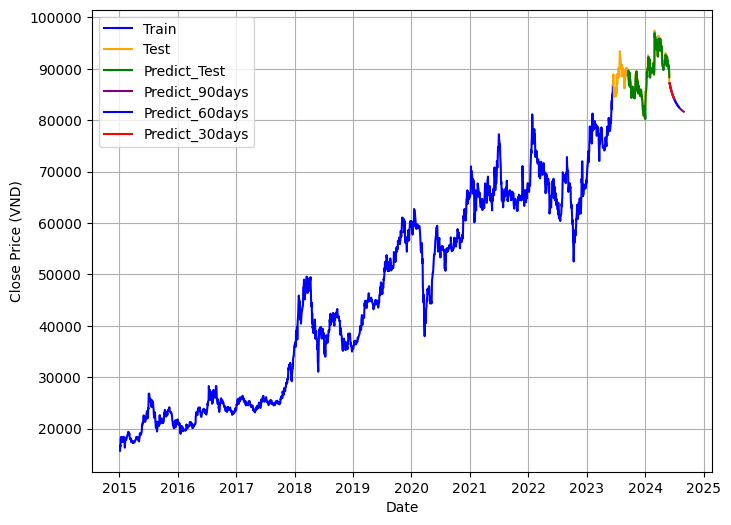

In [2]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')


# plt.title('VCB Stock Price Forecast using LSTM 9:1')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [3]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)


Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  87158.390625
2024-06-02  87223.250000
2024-06-03  87159.445312
2024-06-04  86949.539062
2024-06-05  86725.179688
...                  ...
2024-08-25  81732.875000
2024-08-26  81710.054688
2024-08-27  81687.671875
2024-08-28  81665.742188
2024-08-29  81644.250000

[90 rows x 1 columns]


In [4]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1072.7351236663453
MAPE: 0.8544782183279315 %
MAE: 762.8322108477013


## CTG

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../Dataset/CTG.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (90/10)
train_size = int(len(y_norm) * 0.9)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - loss: 0.0356 - val_loss: 0.0021
Epoch 2/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 3/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 4/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 5/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 6/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 7/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 9.3690e-04 - val_loss: 0.0012
Epoch 8/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 8.6355e-04 - val_loss: 9.9940e-04
Epoch 9/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 7.9264e-04 - val_loss: 9.0586e-04
Epoch 10/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 7.3252e-04 - val_loss: 8.6198e-04
Epoch 11/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 6.8888e-04 - val_loss: 8.2937e-04
Epoch 12/200
65

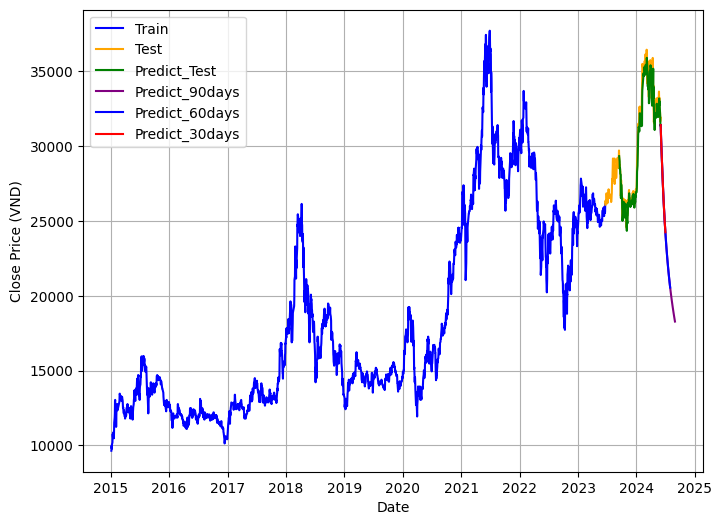

In [6]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('CTG Stock Price Forecast using LSTM 9:1')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [7]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast CTG stock prices for the next 90 days:")
print(future_df)


Forecast CTG stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  31409.187500
2024-06-02  30954.556641
2024-06-03  30576.703125
2024-06-04  30256.535156
2024-06-05  29965.751953
...                  ...
2024-08-25  18532.095703
2024-08-26  18466.574219
2024-08-27  18401.748047
2024-08-28  18337.599609
2024-08-29  18274.113281

[90 rows x 1 columns]


In [8]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 669.614481025369
MAPE: 1.586376775021666 %
MAE: 492.94503348214283


## BID

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../Dataset/BID.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (90/10)
train_size = int(len(y_norm) * 0.9)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - loss: 0.0271 - val_loss: 0.0022
Epoch 2/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 3/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0010 - val_loss: 0.0032
Epoch 4/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 9.0717e-04 - val_loss: 0.0020
Epoch 5/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 8.5079e-04 - val_loss: 0.0012
Epoch 6/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 7.9771e-04 - val_loss: 9.6425e-04
Epoch 7/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 7.2746e-04 - val_loss: 8.6593e-04
Epoch 8/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 6.7325e-04 - val_loss: 7.9715e-04
Epoch 9/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 6.2930e-04 - val_loss: 7.4884e-04
Epoch 10/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 5.9103e-04 - val_loss: 7.1247e-04
Epoch 11/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 5.5604e-04 - val_loss: 6.7989

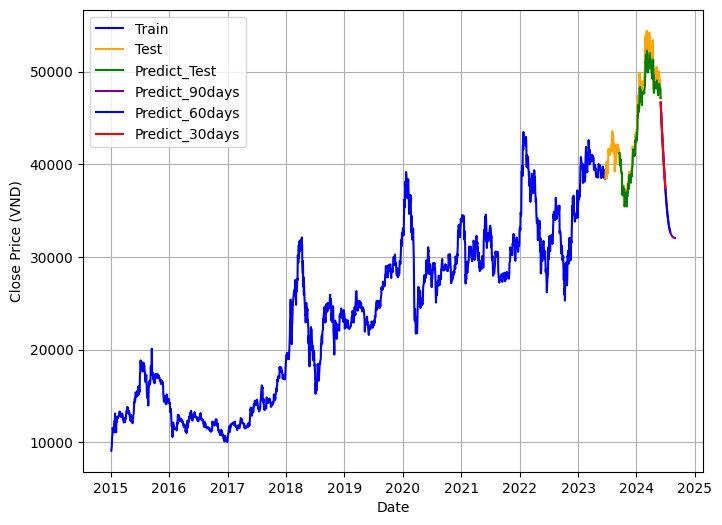

In [13]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('BID Stock Price Forecast using LSTM 9:1')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [11]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast BID stock prices for the next 90 days:")
print(future_df)


Forecast BID stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  46647.394531
2024-06-02  46210.402344
2024-06-03  45794.363281
2024-06-04  45396.433594
2024-06-05  45011.871094
...                  ...
2024-08-25  32056.390625
2024-08-26  32051.105469
2024-08-27  32046.453125
2024-08-28  32042.388672
2024-08-29  32038.869141

[90 rows x 1 columns]


In [12]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1243.0667359921156
MAPE: 2.0351705892642125 %
MAE: 963.4975892857143
